In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
df_filepaths = 'data/univ3/*.parquet'

In [12]:
def get_largest_token_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    q = (
        pl.scan_parquet(df_filepaths)
        .filter(pl.col("blockchain") == blockchain)
        .groupby('tokenIn_symbol')
        .agg(pl.col("amountInUSD").sum())
        .sort(by="amountInUSD", descending=True)
    )
    df = q.collect()
    
    return df

In [13]:
sample_df = get_largest_token_vol(df_filepaths)

PARTITIONED DS


In [15]:
sample_df.head(5)

tokenIn_symbol,amountInUSD
str,f64
"""WETH""",46170347673.34306
"""USDC""",38970690442.35013
"""USDT""",16821957061.165615
"""ARB""",4482087376.719337
"""DAI""",2641947714.462758


### Token Filtering

In [3]:
def filter_tokens(token_symbol: str, df_filepaths: str) -> pl.DataFrame:
    """
    Uses polars streaming API to filter for token symbol in tokenIn or tokenOut without loading entire dataset into memory.
    """
    q_in = (
    pl.scan_parquet(df_filepaths)
    .filter(pl.col('tokenIn_symbol') == token_symbol)
    )

    q_out = (
    pl.scan_parquet(df_filepaths)
    .filter(pl.col('tokenOut_symbol') == token_symbol)
    )

    df = pl.concat([q_in, q_out]).collect(streaming=True)
    return df


In [4]:
weth_filter = filter_tokens('WETH', df_filepaths)

# usdc_filter = filter_tokens('USDC', data)
# usdt_filter = filter_tokens('USDT', data)

In [5]:
# sort weth_filter
weth_filter = weth_filter.sort('timestamp', descending=False)

In [6]:
print(f'WETH has {format(weth_filter.shape[0], ",")} transactions')
# print(f'Out of the {format(data.shape[0], ",")} total transactions, WETH has {format(weth_filter.shape[0], ",")} transactions, USDC has {format(usdc_filter.shape[0], ",")} transactions, and USDT has {format(usdt_filter.shape[0], ",")} transactions.')

WETH has 16,600,649 transactions


### Aggregate Flows

In [7]:
def monthly_blockchain_vol(df: pl.DataFrame, blockchain: list[str]) -> pl.DataFrame:
    '''
    Returns weekly volume for each blockchain in USD
    '''

    blockchain_df = df.filter(pl.col('blockchain') == blockchain)

    # Hourly groupby with Polars
    blockchain_df = blockchain_df.groupby_dynamic("timestamp",every='1mo').agg(pl.col('amountInUSD').sum())

    # round timestamp values to nearest day granularity
    blockchain_df = blockchain_df.select(
        pl.col("timestamp").dt.truncate("1d"),
        pl.col("amountInUSD").alias("weekly_vol")
        )

    return blockchain_df

In [8]:
weth_eth_data = monthly_blockchain_vol(weth_filter, 'ethereum')
weth_arb_data = monthly_blockchain_vol(weth_filter, 'arbitrum')
weth_opt_data = monthly_blockchain_vol(weth_filter, 'optimism')
weth_poly_data = monthly_blockchain_vol(weth_filter, 'polygon')
weth_bsc_data = monthly_blockchain_vol(weth_filter, 'bsc')

In [9]:
# rename columns
eth_data = weth_eth_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('weth vol (eth)')
)

arb_data = weth_arb_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('weth vol (arb)')
)

opt_data = weth_opt_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('weth vol (opt)')
)

poly_data = weth_poly_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('weth vol (poly)')
)

bsc_data = weth_bsc_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('weth vol (bsc)')
)

In [10]:
# merge dataframes
monthly_vol = eth_data.join(arb_data, on='timestamp').join(opt_data, on='timestamp').join(poly_data, on='timestamp').join(bsc_data, on='timestamp', how='outer')

In [11]:
# convert null to 0 
monthly_vol = monthly_vol.fill_null(0)

In [12]:
monthly_vol

timestamp,weth vol (eth),weth vol (arb),weth vol (opt),weth vol (poly),weth vol (bsc)
datetime[μs],f64,f64,f64,f64,f64
2023-03-01 00:00:00,32692194656.99896,8974768427.119448,1164039407.0336637,1421557349.5173063,0
2023-04-01 00:00:00,14375473416.937578,9476490112.651398,575028774.9492655,706893515.5454987,43853.90915066425
2023-05-01 00:00:00,14231388176.409418,5493003064.27326,427460080.8152473,508785759.14101815,57487.10881893993


In [13]:
# print out each row formatted with commas for blockchain_stats
for row in monthly_vol.rows():
    print(f"\n Month: {row[0]}\n eth vol: ${row[1]:,.0f}\n arb vol: ${row[2]:,.0f}\n bsc vol: ${row[5]:,.0f}\n poly vol: ${row[4]:,.0f}\n opt vol: ${row[3]:,.0f}")


 Month: 2023-03-01 00:00:00
 eth vol: $32,692,194,657
 arb vol: $8,974,768,427
 bsc vol: $0
 poly vol: $1,421,557,350
 opt vol: $1,164,039,407

 Month: 2023-04-01 00:00:00
 eth vol: $14,375,473,417
 arb vol: $9,476,490,113
 bsc vol: $43,854
 poly vol: $706,893,516
 opt vol: $575,028,775

 Month: 2023-05-01 00:00:00
 eth vol: $14,231,388,176
 arb vol: $5,493,003,064
 bsc vol: $57,487
 poly vol: $508,785,759
 opt vol: $427,460,081


In [14]:
pd_monthly_chart = monthly_vol.to_pandas()
# convert timestamp to datetime so it just shows the date, not the time.
pd_monthly_chart['timestamp'] = pd.to_datetime(pd_monthly_chart['timestamp']).dt.date

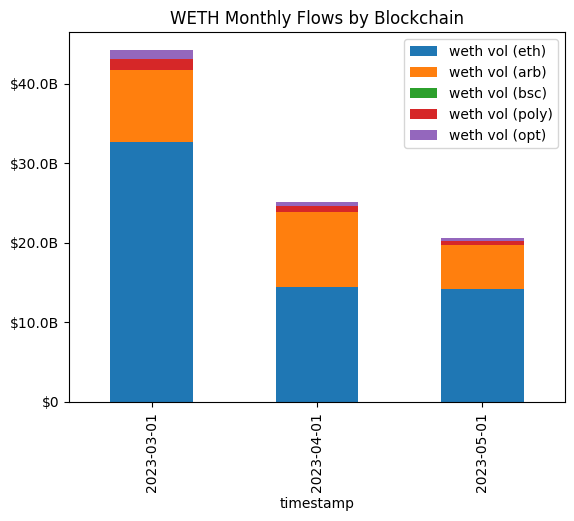

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create the bar chart
ax = pd_monthly_chart.plot.bar(x='timestamp', y=['weth vol (eth)', 'weth vol (arb)', 'weth vol (bsc)', 'weth vol (poly)', 'weth vol (opt)'], stacked=True, title='WETH Monthly Flows by Blockchain')

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'

# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# Display the plot
plt.show()